In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
import os
import json

from ExptTrace import ExptTrace
from FileManager import FileManager
from misc import rcsetup

rcsetup()

sys.path.append("../")
from utils import ensure_torch, ensure_numpy
from kernels import GaussianKernel, LaplaceKernel, ReluNTK
from eigenlearning import compute_learnabilities, learning_curve
from feature_decomp import Monomial

In [2]:
import matplotlib.colors as mcolors

def lighten(color, amount=0.5):
    rgb = mcolors.to_rgb(mcolors.XKCD_COLORS.get(color, color))
    if amount >= 0:
        new_rgb = tuple(c + (1 - c) * amount for c in rgb)
    else:
        new_rgb = tuple(c * (1 + amount) for c in rgb)
    # Clip values to [0, 1]
    new_rgb = tuple(min(max(x, 0), 1) for x in new_rgb)
    return new_rgb

# Fig 1

In [3]:
import importlib
import expts.expt_demux
importlib.reload(expts.expt_demux)
from expts.expt_demux import expt_demux

def load_results(expt_id):
    EXPT_NAME = "learning-curves"

    hypers = expt_demux(expt_id)

    N_SAMPLES = hypers['n_samples']
    N_KERNEL = hypers['n_kernel']
    N_TRAIN_MAX = hypers['n_train_max']
    N_TEST = hypers['n_test']
    P_MODES = hypers['p_modes']
    DATASET = hypers['dataset']
    DATA_DIM = hypers['data_dim']
    DATA_EIGVAL_EXP = hypers['data_eigval_exp']
    ZCA_STRENGTH = hypers['zca_strength']
    NORMALIZE = hypers['normalize']
    TARGET = hypers['target']
    NUM_MARKERS = hypers['num_markers']
    KERNEL_NAME = hypers['kernel_name']
    KERNEL_WIDTH = hypers['kernel_width']
    RIDGE = hypers['ridge']
    FEWER_TRIALS = hypers['fewer_trials']

    datapath = os.getenv("DATASETPATH")
    exptpath = os.getenv("EXPTPATH")
    if datapath is None:
        raise ValueError("must set $DATASETPATH environment variable")
    if exptpath is None:
        raise ValueError("must set $EXPTPATH environment variable")
    fp = f"{KERNEL_NAME}-kw:{KERNEL_WIDTH}-target:{TARGET}"
    if DATASET == "gaussian":
        fp += f"-data:{DATA_DIM}:{DATA_EIGVAL_EXP}"
    else:
        fp += f"-zca:{ZCA_STRENGTH}"
    expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET, fp)

    if not os.path.exists(expt_dir):
        assert False, f"Experiment directory {expt_dir} does not exist"
    expt_fm = FileManager(expt_dir)
    
    with open(expt_fm.get_filename("hypers.json"), 'r') as f:
        hypers = json.load(f)
    result = expt_fm.load("result.pickle")
    targets = expt_fm.load("targets.pickle")
    coeffs = expt_fm.load("coeffs.pickle")
    return hypers, result, targets, coeffs


In [4]:
def add_lrn_curves(ax, expt_id, **kwargs):
    colors = ['xkcd:black', 'xkcd:raspberry', 'xkcd:cerulean', 'xkcd:grass', 'xkcd:tangerine']
    hypers, result, targets, coeffs = load_results(expt_id)
    RIDGE = hypers.get("ridge", 1e-3)
    TARGET = hypers.get("target", "powerlaws")
    label = kwargs.get("label", TARGET)
    color_idx = kwargs.get("color", 0)
    color = colors[color_idx % len(colors)]

    d_eff = result["d_eff"]
    print(f"d_eff = {d_eff:.2f}")
    et_mse = ExptTrace.deserialize(result["mse"])
    ntrains = et_mse.get_axis("ntrain")
    emp_eigvals = result["emp_eigvals"]
    emp_eigvals = np.maximum(emp_eigvals, 0)
    hehe_eigvals = result["th_eigvals"]

    target = list(targets.keys())[0]

    v_hat, v_emp = coeffs[target]
    
    xmin = kwargs.get("xmin", 8)
    xmax = kwargs.get("xmax", 2e4)

    mse = et_mse[:, :, target].squeeze()
    lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
    ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(color, 0.5),
                ls='none', marker='o', zorder=-4)

    # emp_learnabilities, _ = compute_learnabilities(ntrains_dense, emp_eigvals, RIDGE)
    # lrn_curve_emp = learning_curve(ntrains_dense, emp_learnabilities, v_emp)
    # ax.plot(ntrains_dense, lrn_curve_emp, color=color, lw=2, ls=":")
    
    TrK = 1.0
    ntrains_dense = np.logspace(np.log10(xmin), np.log10(xmax), 200)
    hehe_ridge = RIDGE + max(0, TrK - hehe_eigvals.sum())
    learnabilities, _ = compute_learnabilities(ntrains_dense, hehe_eigvals, hehe_ridge)
    th_noise_var = 1 - np.linalg.norm(v_hat)**2
    lrn_curve_th = learning_curve(ntrains_dense, learnabilities, v_hat, noise_var=th_noise_var)
    ax.plot(ntrains_dense, lrn_curve_th, color=color, lw=2, ls="-", label=label)

In [5]:
from tqdm import tqdm

def get_sample_complexities(expt_id, **kwargs):
    hypers, result, targets, coeffs = load_results(expt_id)
    RIDGE = hypers.get("ridge")

    d_eff = result["d_eff"]
    et_mse = ExptTrace.deserialize(result["mse"])
    ntrains = et_mse.get_axis("ntrain")
    hehe_eigvals = result["th_eigvals"]
    monomials = result["monomials"]

    threshold = kwargs.get("threshold", 0.5)
    sample_complexities = {}
    ntrains_dense = np.logspace(np.log10(1), np.log10(20_000), 200)
    for idx, _ in tqdm(targets.items()):
        ntrains = et_mse.get_axis("ntrain")
        mse = et_mse[:, :, idx].squeeze()
        lrn_curve_emp = mse.mean(axis=0)
        
        n_cross = 10**np.interp(threshold, lrn_curve_emp[::-1], np.log10(ntrains)[::-1])
        if n_cross > 0.99 * ntrains[-1]:
            continue

        v_hat, _ = coeffs[idx]
        TrK = 1.0
        hehe_ridge = RIDGE + max(0, TrK - hehe_eigvals.sum())
        learnabilities, _ = compute_learnabilities(ntrains_dense, hehe_eigvals, hehe_ridge)
        th_noise_var = 1 - np.linalg.norm(v_hat)**2
        lrn_curve_th = learning_curve(ntrains_dense, learnabilities, v_hat, noise_var=th_noise_var)
        n_cross_th = 10**np.interp(threshold, lrn_curve_th[::-1], np.log10(ntrains_dense)[::-1])

        sample_complexities[idx] = (n_cross, n_cross_th)
    return monomials, sample_complexities

In [6]:
monomials, sample_complexities = get_sample_complexities(8, threshold=0.5)

100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


d_eff = 9.50
d_eff = 10.85
d_eff = 10.15
d_eff = 9.31
d_eff = 5.39


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


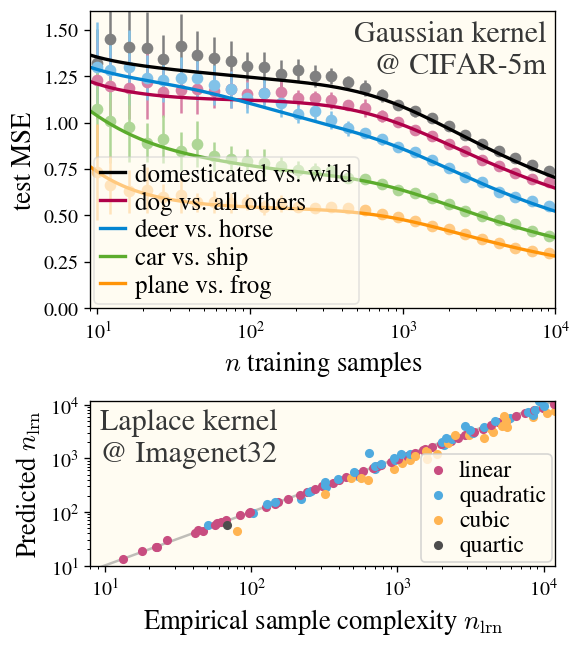

In [19]:
import matplotlib.lines as mlines

fig, axes = plt.subplots(nrows=2, figsize=(5, 6),
                         gridspec_kw={'height_ratios': [9, 5], 'hspace': 0.4})

ax = axes[0]
xmin, xmax = 9, 1e4
for i, expt_id in enumerate([2, 6, 7, 4, 3]):
    if expt_id == 2:
        label = "domesticated vs. wild"
    if expt_id == 3:
        label = "plane vs. frog"
    if expt_id == 4:
        label = "car vs. ship"
    if expt_id == 6:
        label = "dog vs. all others"
    if expt_id == 7:
        label = "deer vs. horse"
    add_lrn_curves(ax, expt_id, xmin=xmin, xmax=xmax,
               color=i, label=label)

ax.set_xlabel(f"$n$ training samples", fontsize=16)
ax.set_ylabel("test MSE", fontsize=16)
ax.text(0.98, 0.97, f"Gaussian kernel\n@ CIFAR-5m", ha="right", va="top",
        transform=ax.transAxes, fontsize=18, color="xkcd:dark gray")
ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1.6)
ax.legend(fontsize=15, framealpha=0.5,
          handlelength=1, labelspacing=0.15,
          borderpad=0.25, bbox_to_anchor=(0, 0),  # Anchor to the very bottom left
          loc='lower left',
          handletextpad=0.4,      # Minimize space between handle and text
          borderaxespad=0.15,      # Minimize outer padding from axes
          )

# $x_{1}x_{3}x_{4}$ $x_{0}x_{2}x_{8}$
ax = axes[1]
tags = [{1:1}, {5:1}, {100:1}, {204:1},
        {0:2}, {0:1,2:1}, {1:1, 3:1}, {10:1,13:1}, {20:1,30:1},
        {0:3}, {0:2, 2:1}, {0:1, 1:1, 2:1}, {3:2, 5:1},
        {0:4}]
locs = [3, 3, 3, 3,
        3, 0, 3, 3, 0,
        0, 0, 0, 0,
        1]

# colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue']
colors = ['xkcd:red', 'xkcd:raspberry', 'xkcd:cerulean', 'xkcd:tangerine', 'xkcd:black']
labeldone = [False] * len(colors)
labels = ["constant", "linear", "quadratic", "cubic", "quartic"]
for idx, (n_emp, n_th) in sample_complexities.items():
    m = Monomial(monomials[idx])
    color = lighten(colors[m.degree() % len(colors)], 0.3)
    # alpha = 0.3
    # zorder = -3
    if n_th > 2*n_emp:
        continue
    label = None
    alpha = 1
    zorder = 1
    if m in tags:
        # i = tags.index(monomials[idx])
        # kwargs = {"ha": "left" if locs[i] < 2 else "right",
        #           "va": "bottom" if locs[i] % 2 == 1 else "top"}
        # z = 0.05
        # off = (
        #     z if locs[i] < 2 else -z,
        #     z if locs[i] % 2 == 1 else -z
        # )
        # if m == {3:2, 5:1}:
        #     kwargs["ha"] = "center"
        #     off = (off[0]+0.2, off[1])
        # ax.annotate(str(m), (n_emp*(1+off[0]), n_th*(1+off[1])), fontsize=15,
        #             color=lighten(color, -0.2), alpha=0.7, **kwargs)
        # alpha = 1.0
        # zorder = 1
        label = None if labeldone[m.degree()] else labels[m.degree()]
        labeldone[m.degree()] = True
    ax.scatter(n_emp, n_th, color=color, s=30, alpha=alpha, lw=0, zorder=zorder, label=label)

ax.text(0.02, 0.95, f"Laplace kernel\n@ Imagenet32", ha="left", va="top",
        transform=ax.transAxes, fontsize=18, color="xkcd:dark gray")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(8, 1.2e4)
ax.set_ylim(10, 1.2e4)
ax.plot([1, 2e4], [1, 2e4], color="gray", alpha=0.5, zorder=-4)
ax.legend(fontsize=14, framealpha=0.8,
          handlelength=1, labelspacing=0.15,
          borderpad=0.25,
          loc='lower right',
          handletextpad=0.4,
          borderaxespad=0.15,
          )
ax.set_xlabel(f"Empirical sample complexity $n_\\mathrm{{lrn}}$", fontsize=16)
ax.set_ylabel(f"Predicted $n_\\mathrm{{lrn}}$", fontsize=16)

plt.savefig("fig1-plots.pdf", bbox_inches='tight')
# plt.show()

In [13]:
for idx, (n_emp, n_th) in sample_complexities.items():
    m = Monomial(monomials[idx])
    print(str(m))

$x_{0}$
$x_{1}$
$x_{2}$
$x_{3}$
$x_{4}$
$x_{5}$
$x_{6}$
$x_{7}$
$x_{8}$
$x_{0}^2$
$x_{9}$
$x_{10}$
$x_{11}$
$x_{12}$
$x_{14}$
$x_{17}$
$x_{0}x_{1}$
$x_{18}$
$x_{21}$
$x_{24}$
$x_{0}x_{2}$
$x_{26}$
$x_{1}^2$
$x_{30}$
$x_{0}x_{4}$
$x_{0}^3$
$x_{32}$
$x_{37}$
$x_{0}x_{5}$
$x_{1}x_{2}$
$x_{41}$
$x_{1}x_{3}$
$x_{47}$
$x_{0}x_{6}$
$x_{52}$
$x_{0}^2x_{1}$
$x_{0}x_{8}$
$x_{59}$
$x_{2}x_{3}$
$x_{67}$
$x_{0}^4$
$x_{0}x_{10}$
$x_{76}$
$x_{0}^2x_{2}$
$x_{1}x_{6}$
$x_{85}$
$x_{0}^2x_{3}$
$x_{0}^2x_{4}$
$x_{1}x_{8}$
$x_{95}$
$x_{100}$
$x_{4}x_{5}$
$x_{105}$
$x_{2}x_{6}$
$x_{0}^2x_{5}$
$x_{119}$
$x_{0}x_{1}x_{2}$
$x_{0}x_{19}$
$x_{134}$
$x_{0}x_{1}x_{3}$
$x_{0}x_{22}$
$x_{148}$
$x_{0}^2x_{6}$
$x_{2}x_{10}$
$x_{163}$
$x_{0}^2x_{8}$
$x_{1}x_{18}$
$x_{184}$
$x_{190}$
$x_{0}x_{2}x_{3}$
$x_{3}x_{11}$
$x_{204}$
$x_{0}^2x_{10}$
$x_{0}x_{35}$
$x_{228}$
$x_{0}x_{4}^2$
$x_{0}x_{40}$
$x_{253}$
$x_{1}x_{2}^2$
$x_{1}x_{28}$
$x_{281}$
$x_{0}x_{3}x_{5}$
$x_{2}x_{22}$
$x_{313}$
$x_{0}x_{2}x_{6}$
$x_{0}x_{56}$
$x_{34

# lrn curve

In [3]:
def load_results(expt_id):
    EXPT_NAME = "learning-curves"

    # Defaults
    DATASET = "gaussian"
    DATA_DIM = 200
    DATA_EIGVAL_EXP = 2.0
    ZCA_STRENGTH = 0
    NORMALIZE = False
    TARGET = "powerlaws"
    source_exps = [1.15]
    KERNEL_TYPE = GaussianKernel
    KERNEL_WIDTH = 4
    RIDGE = 1e-3
        
    if expt_id == 1:
        DATASET = "cifar5m"
        TARGET = "vehicle"
    if expt_id == 2:
        DATASET = "cifar5m"
        TARGET = "domesticated"
    if expt_id == 3:
        DATASET = "cifar5m"
        TARGET = "plane-frog"
    if expt_id == 4:
        DATASET = "cifar5m"
        TARGET = "car-ship"
    if expt_id == 5:
        DATASET = "cifar5m"
        TARGET = "bird-cat"
    if expt_id == 6:
        DATASET = "cifar5m"
        TARGET = "dog-else"
    if expt_id == 7:
        DATASET = "cifar5m"
        TARGET = "deer-horse"
    if expt_id == 8:
        DATASET = "imagenet32"
        TARGET = "monomials"
        KERNEL_TYPE = LaplaceKernel
        NUM_MARKERS = 50
        ZCA_STRENGTH = 1e-3
        NORMALIZE = True
        FEWER_TRIALS = True
    if expt_id == 9:
        DATASET = "cifar10"
        TARGET = "monomials"
    if expt_id == 10:
        DATASET = "imagenet32"
        TARGET = "powerlaws"
        KERNEL_TYPE = LaplaceKernel
        ZCA_STRENGTH = 1e-2
        NORMALIZE = True

    datapath = os.getenv("DATASETPATH")
    exptpath = os.getenv("EXPTPATH")
    if datapath is None:
        raise ValueError("must set $DATASETPATH environment variable")
    if exptpath is None:
        raise ValueError("must set $EXPTPATH environment variable")
    fp = f"{KERNEL_TYPE.__name__}-kw:{KERNEL_WIDTH}-target:{TARGET}"
    if DATASET == "gaussian":
        fp += f"-data:{DATA_DIM}:{DATA_EIGVAL_EXP}"
    else:
        fp += f"-zca:{ZCA_STRENGTH}"
    expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET, fp)

    if not os.path.exists(expt_dir):
        assert False, f"Experiment directory {expt_dir} does not exist"
    expt_fm = FileManager(expt_dir)
    
    with open(expt_fm.get_filename("hypers.json"), 'r') as f:
        hypers = json.load(f)
    result = expt_fm.load("result.pickle")
    targets = expt_fm.load("targets.pickle")
    coeffs = expt_fm.load("coeffs.pickle")
    return hypers, result, targets, coeffs


d_eff = 9.50
d_eff = 10.85
d_eff = 10.15
d_eff = 9.31
d_eff = 5.39


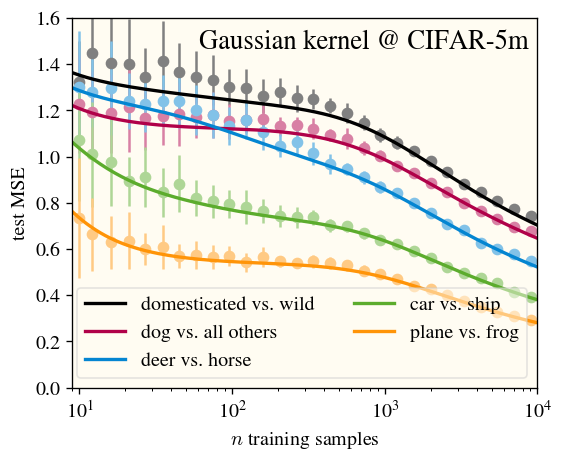

In [4]:
colors = ['xkcd:black', 'xkcd:raspberry', 'xkcd:cerulean', 'xkcd:grass', 'xkcd:tangerine']

def add_curves(ax, expt_id, **kwargs):
    hypers, result, targets, coeffs = load_results(expt_id)
    RIDGE = hypers.get("ridge", 1e-3)
    TARGET = hypers.get("target", "powerlaws")
    label = kwargs.get("label", TARGET)
    color_idx = kwargs.get("color", 0)
    color = colors[color_idx % len(colors)]

    d_eff = result["d_eff"]
    print(f"d_eff = {d_eff:.2f}")
    et_mse = ExptTrace.deserialize(result["mse"])
    ntrains = et_mse.get_axis("ntrain")
    emp_eigvals = result["emp_eigvals"]
    emp_eigvals = np.maximum(emp_eigvals, 0)
    hehe_eigvals = result["th_eigvals"]

    target = list(targets.keys())[0]

    v_hat, v_emp = coeffs[target]
    
    xmin = kwargs.get("xmin", 8)
    xmax = kwargs.get("xmax", 2e4)

    mse = et_mse[:, :, target].squeeze()
    lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
    ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(color, 0.5),
                ls='none', marker='o', zorder=-4)

    # emp_learnabilities, _ = compute_learnabilities(ntrains_dense, emp_eigvals, RIDGE)
    # lrn_curve_emp = learning_curve(ntrains_dense, emp_learnabilities, v_emp)
    # ax.plot(ntrains_dense, lrn_curve_emp, color=color, lw=2, ls=":")
    
    TrK = 1.0
    ntrains_dense = np.logspace(np.log10(xmin), np.log10(xmax), 200)
    hehe_ridge = RIDGE + max(0, TrK - hehe_eigvals.sum())
    learnabilities, _ = compute_learnabilities(ntrains_dense, hehe_eigvals, hehe_ridge)
    th_noise_var = 1 - np.linalg.norm(v_hat)**2
    lrn_curve_th = learning_curve(ntrains_dense, learnabilities, v_hat, noise_var=th_noise_var)
    ax.plot(ntrains_dense, lrn_curve_th, color=color, lw=2, ls="-", label=label)
    
fig, ax = plt.subplots(figsize=(5, 4))

xmin, xmax = 9, 1e4

for i, expt_id in enumerate([2, 6, 7, 4, 3]):
    if expt_id == 2:
        label = "domesticated vs. wild"
    if expt_id == 3:
        label = "plane vs. frog"
    if expt_id == 4:
        label = "car vs. ship"
    if expt_id == 6:
        label = "dog vs. all others"
    if expt_id == 7:
        label = "deer vs. horse"
    add_curves(ax, expt_id, xmin=xmin, xmax=xmax,
               color=i, label=label)

ax.set_xlabel(f"$n$ training samples")
ax.set_ylabel("test MSE")
ax.text(0.98, 0.97, f"Gaussian kernel @ CIFAR-5m", ha="right", va="top",
        transform=ax.transAxes, fontsize=16)

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1.6)
ax.legend(ncols=2, framealpha=0.5)
plt.show()

# Monomial expt

In [5]:
hypers, result, targets, coeffs = load_results(8)
# N_SAMPLES = hypers.get("n_samples", 80_000)
# N_TEST = hypers.get("n_test", 5_000)
# P_MODES = hypers.get("p_modes", 30_000)
RIDGE = hypers.get("ridge")
KERNEL_NAME = hypers.get("kernel_name")
DATASET = hypers.get("dataset")
TARGET = hypers.get("target")
print(KERNEL_NAME, DATASET, TARGET)

d_eff = result["d_eff"]
print(f"d_eff = {d_eff:.2f}")
et_mse = ExptTrace.deserialize(result["mse"])
ntrains = et_mse.get_axis("ntrain")
hehe_eigvals = result["th_eigvals"]
monomials = result["monomials"]

LaplaceKernel imagenet32 monomials
d_eff = 21.67


In [6]:
from tqdm import tqdm

threshold = 0.5
sample_complexities = {}
ntrains_dense = np.logspace(np.log10(1), np.log10(20_000), 200)
for idx, ystar in tqdm(targets.items()):
    ntrains = et_mse.get_axis("ntrain")
    mse = et_mse[:, :, idx].squeeze()
    mse = mse * 5/8
    lrn_curve_emp = mse.mean(axis=0)
    
    n_cross = 10**np.interp(threshold, lrn_curve_emp[::-1], np.log10(ntrains)[::-1])
    if n_cross > 0.99 * ntrains[-1]:
        continue

    v_hat, v_emp = coeffs[idx]
    TrK = 1.0
    hehe_ridge = RIDGE + max(0, TrK - hehe_eigvals.sum())
    learnabilities, _ = compute_learnabilities(ntrains_dense, hehe_eigvals, hehe_ridge)
    th_noise_var = 1 - np.linalg.norm(v_hat)**2
    lrn_curve_th = learning_curve(ntrains_dense, learnabilities, v_hat, noise_var=th_noise_var)
    n_cross_th = 10**np.interp(threshold, lrn_curve_th[::-1], np.log10(ntrains_dense)[::-1])

    sample_complexities[idx] = (n_cross, n_cross_th)

100%|██████████| 35/35 [00:18<00:00,  1.91it/s]


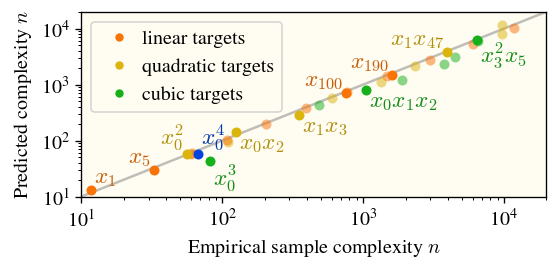

In [ ]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(5, 2))

tags = [{1:1}, {5:1}, {100:1}, {190:1},
        {0:2}, {0:1,2:1}, {1:1, 3:1}, {1:1,47:1}, {20:1,30:1},
        {0:3}, {0:1, 1:1, 2:1}, {3:2, 5:1},
        {0:4}]
locs = [1, 3, 3, 3,
        3, 0, 0, 3, 0,
        0, 0, 0,
        1]

colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue']
for idx, (n_emp, n_th) in sample_complexities.items():
    m = Monomial(monomials[idx])
    color = colors[m.degree() % len(colors)]
    alpha = 0.5
    zorder = -3
    if m in tags:
        i = tags.index(monomials[idx])
        kwargs = {"ha": "left" if locs[i] < 2 else "right",
                  "va": "bottom" if locs[i] % 2 == 1 else "top"}
        z = 0.05
        off = (
            z if locs[i] < 2 else -z,
            z if locs[i] % 2 == 1 else -z
        )
        ax.annotate(str(m), (n_emp*(1+off[0]), n_th*(1+off[1])), fontsize=14, bbox=dict(boxstyle='square,pad=1', alpha=0),
                color=lighten(color, -0.2), **kwargs)
        alpha = 1.0
        zorder = 1
    ax.scatter(n_emp, n_th, color=color, alpha=alpha, lw=0, zorder=zorder)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(10, 2e4)
ax.set_ylim(10, 2e4)
ax.plot([1, 2e4], [1, 2e4], color="gray", alpha=0.5, zorder=-4)
ax.set_xlabel(f"Empirical sample complexity $n$")
ax.set_ylabel(f"Predicted complexity $n$")

marker_kwargs = dict(marker='.', lw=0, markersize=8)
legend_handles = [
    mlines.Line2D([], [], color='xkcd:orange', **marker_kwargs, label='linear targets'),
    mlines.Line2D([], [], color='xkcd:gold', **marker_kwargs, label='quadratic targets'),
    mlines.Line2D([], [], color='xkcd:green', **marker_kwargs, label='cubic targets'),
]
ax.legend(handles=legend_handles, loc='best', handletextpad=0.15)

plt.show()